# Using the FEMesh class

## Prerequisites

The following Python package are required
* `numpy` and `matplotlib`
* `objdict`
* `palettable`

Then, the following imports should work.

In [63]:
from math import sin, pi
from FEMesh import readmsh

import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Introduction

The FEMesh class provides a simple interface to a mesh generated by the Gmsh application. Gmsh allows the definition of so called [physical groups](https://gmsh.info/doc/texinfo/gmsh.html#Elementary-entities-vs-physical-groups). Accordingly, the `FEMesh` class can be used in a simple mode (no physical groups) and an advanced mode (with physical groups). The differences are explained in the following two sections. The last section explains how these two scenarios are connected.

Notes:

* Implementation is neither fast, memory efficient or complete
* Use is limited to moderately sized 2D meshes. Triangular and quadrilateral elements can not be mixed

## Simple mode (no physical groups defined)

The mesh is loaded using the function `readmsh(<filename>)` which returns an object of type `FEMesh`. Use the `plot()` method to display the mesh.

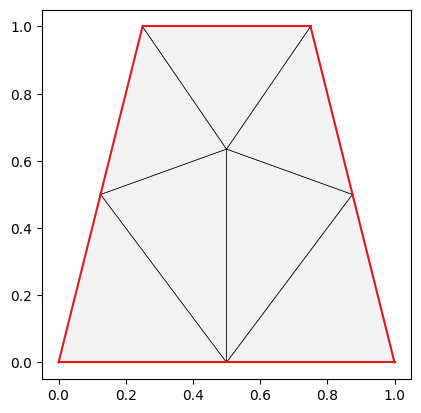

In [64]:
m1 = readmsh('gmsh/simple.msh')
m1.plot()

The `FEMesh` object provides access to
* the number of nodes and node coordinates
* the number of elements $N_\mathrm{e}$ and elements
* IDs of nodes located on edges
* ID of a node at a certain position

In [65]:
print('Number of nodes: ', m1.Nn)
print('Node coordinates:\n', m1.nodes)
print('Number of elements: ', m1.Ne)
print('Elements:\n', m1.elements)
print('Edge node IDs:\n', m1.edgeNodeIDs)
print('ID of node at (0.75, 1):\n', m1.findNodeAt(0.75, 1.0))

Number of nodes:  8
Node coordinates:
 [[0.         1.         0.75       0.25       0.5        0.875
  0.125      0.5       ]
 [0.         0.         1.         1.         0.         0.5
  0.5        0.63520408]]
Number of elements:  7
Elements:
 [[4 5 6 1 2 6 3]
 [7 7 0 5 7 7 7]
 [6 4 4 4 5 3 2]]
Edge node IDs:
 [0, 1, 2, 3, 4, 5, 6]
ID of node at (0.75, 1):
 2


The mesh provides an attribute `p` of type `ObjDict` which can be used to define properties. Here an example, where we set a function `f`:

In [66]:
m1.p.f = sin
print('sin(pi/2) =', m1.p.f(pi / 2))

sin(pi/2) = 1.0


In order to test if a property is defined, one can use the property name and the keyword `in`:

In [67]:
if 'f' in m1.p:
    print('Property f is defined')
if 'g' not in m1.p:
    print('Property g is not defined')

Property f is defined
Property g is not defined


A slightly more complex example illustrates nodes on edges (with an additional plot).

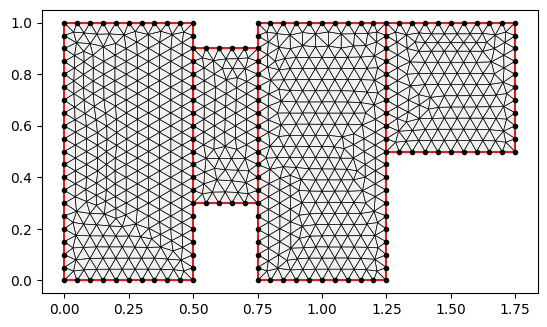

In [68]:
m2 = readmsh('gmsh/complex-ng.msh')
m2.plot()
plt.plot(m2.nodes[0, m2.edgeNodeIDs], m2.nodes[1, m2.edgeNodeIDs], 'o', markersize=3, color='black')

## Advanced mode: Mesh has physical groups

The mesh is loaded as before. However, in the plot, surfaces and edges are colored according to the physical group.

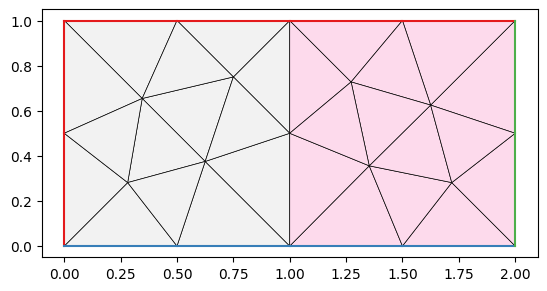

In [69]:
m3 = readmsh('gmsh/advanced.msh')
m3.plot()

In this example, there are three groups of 1D and two groups of 2D elements as defined in [advanced.geo](gmsh/advanced.geo).

The names of defined physical groups are accessed by `groupNames`:

In [70]:
m3.groupNames

['edges', 'faces', 'c1', 'c2', 'c3', 's1', 's2']

An individual group is adressed via the `groups` property of the mesh and the group name. A group has the following properties:
* Name
* Number of nodes, node IDs and node coordinates
* Number of elements and elements

In [71]:
g = m3.groups.c1
print('Name:', g.name)
print('Number of nodes:', g.Nn)
print('Node IDs:\n', g.nodeIDs)
print('Node coordinates:\n', g.nodes)
print('Number of elements:', g.Ne)
print('Elements:\n', g.elements)


Name: c1
Number of nodes: 7
Node IDs:
 [0, 2, 3, 5, 8, 9, 12]
Node coordinates:
 [[0.  1.  0.  2.  0.5 0.  1.5]
 [0.  1.  1.  1.  1.  0.5 1. ]]
Number of elements: 6
Elements:
 [[ 2  8  3  9  5 12]
 [ 8  3  9  0 12  2]]


Groups can also be accessed via `groups[name]`. This comes especially handy if all groups should be processed in a loop:

In [72]:
for n in m3.groupNames:
    g = m3.groups[n]
    print('Group \'' + g.name + '\' has', g.Ne, 'elements')

Group 'edges' has 12 elements
Group 'faces' has 28 elements
Group 'c1' has 6 elements
Group 'c2' has 4 elements
Group 'c3' has 2 elements
Group 's1' has 14 elements
Group 's2' has 14 elements


### Logical groups

You might have noticed that the group names in the example above contain the 'edges' and 'faces' groups which are not defined in the .geo file. These groups are automatically added by `FEMesh` and comprise all elements defined on edges and surfaces respectively.

### Gmsh and physical groups

It is important to understand that Gmsh, if physical groups are defined, by default only exports elements which are attached to at least one physical group (see second paragraph in [Section 6.2 of the Gmsh documentation](https://gmsh.info/doc/texinfo/gmsh.html#Elementary-entities-vs-physical-groups)). Note that the `Mesh.SaveAll=1` option currently does not work with `FEMesh`.

The following two examples illustrate this behaviour. 

#### Example 1

In [complex-g1.geo](gmsh/complex-g1.geo), there are physical names for three edges and all surfaces defined.

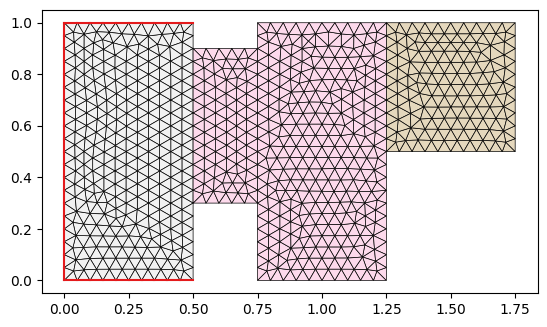

In [73]:
m4 = readmsh('gmsh/complex-g1.msh')
m4.plot()

#### Example 2

In [complex-g2.geo](gmsh/complex-g2.geo), there are physical names for 6 edges but only some of the surfaces defined.

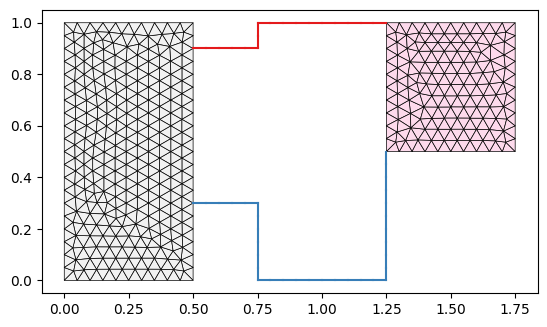

In [74]:
m5 = readmsh('gmsh/complex-g2.msh')
m5.plot()

## The connection: Groups in simple mode

The logical groups `edges` and `faces` are always present. The properties `Ne`, `p` and `elements` of `FEMesh` are simply pointers to the corresponding properties of `faces` and `edgeNodeIDs` refers to `nodeIDs` of `edges`.

In [75]:
m6 = readmsh('gmsh/simple.msh')
m6.p.test = 999

print()
print('Mesh')
print('Property \'test\':', m6.p.test)
print('Elements:\n', m6.elements)
print('Edge node IDs:\n', m6.edgeNodeIDs)

print()
print('Groups')
print('Property \'test\' of \'faces\' group:', m6.groups.faces.p.test)
print('Elements of \'faces\' group:\n', m6.groups.faces.elements)
print('Node IDs of \'edges\' group:\n', m6.groups.edges.nodeIDs)


Mesh
Property 'test': 999
Elements:
 [[4 5 6 1 2 6 3]
 [7 7 0 5 7 7 7]
 [6 4 4 4 5 3 2]]
Edge node IDs:
 [0, 1, 2, 3, 4, 5, 6]

Groups
Property 'test' of 'faces' group: 999
Elements of 'faces' group:
 [[4 5 6 1 2 6 3]
 [7 7 0 5 7 7 7]
 [6 4 4 4 5 3 2]]
Node IDs of 'edges' group:
 [0, 1, 2, 3, 4, 5, 6]


# Plot with scalar values

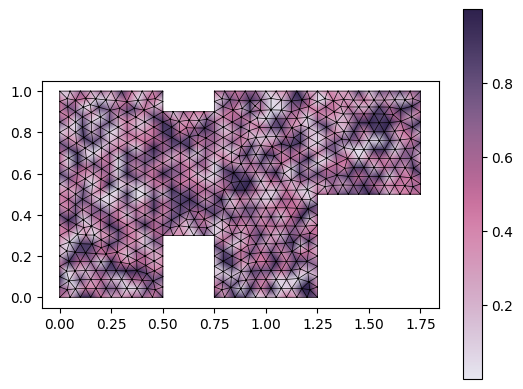

In [88]:
m5 = readmsh('gmsh/complex-g1.msh')
m5.plot(np.random.rand(m5.Nn))

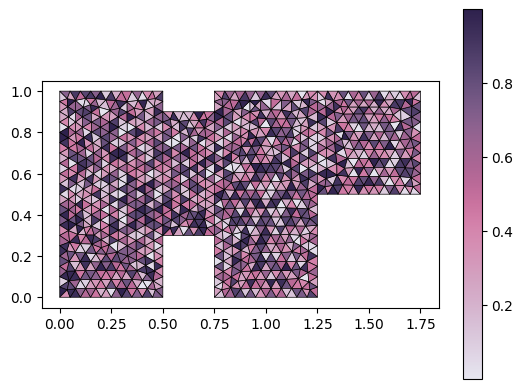

In [87]:
m5.plot(np.random.rand(m5.Ne))

(2, 750)